# Computing the partial Pair Distribution Functions and 2D projected Pair Distribution Functions from an amorphous structure

In [1]:
import numpy as np
import numpy.random as random
import numpy.fft as ft
import numpy.linalg as la
import matplotlib as matplotlib
import matplotlib.pyplot as p
import math
import scipy as sp
import scipy.io as io
%matplotlib inline
import scipy.ndimage.filters as filters
import scipy.optimize as op
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
import ase, ase.io

Let's define a few functions function that can generate different phase functions, the k-space grid, a defocusing function, etc. We will define the unit to be **Angstrom**.

In [2]:
def createGrid(Nx,Ny,xrange,yrange):
    dx = xrange/(Nx-1)
    dy = yrange/(Ny-1)
    grid2 = np.mgrid[-yrange/2.0:yrange/2.0+dy:dy,-xrange/2.0:xrange/2.0+dx:dx]
    x = grid2[1]
    y = grid2[0]
    return x,y,dx,dy

def createReciprocalSpaceGrid(Nx,Ny,dx,dy,kmaxScale,kmaxScale2):
    global kX, kY, k2, kmod

    # The pixel size in k-space is determined by the range in real space:
    dkx = 2.0*np.pi/(x[0][-1]-x[0][0]+dx)
    # Now that we have determined the size of the padded array we can construct the respective reciprocal space grid:
    kX = 2.0*np.pi*np.tile(ft.fftfreq(NpixX,dx).reshape(1,NpixX),(NpixY,1))
    kY = 2.0*np.pi*np.tile(ft.fftfreq(NpixY,dy).reshape(NpixY,1),(1,NpixX))
    print("dkx = ",dkx," (",(kX[0][3]-kX[0][2]),"), NpixX = ",NpixX, ", dx = ",dx)
    k2 = kX**2+kY**2
    kmod = np.sqrt(k2)
    mask = np.ones_like(kX)
    if kmaxScale > 0:
        kmaxx = min((np.amax(kY),np.amax(kY)))
        kmax = kmaxScale*kmaxx
        if kmaxScale2 > 0:
            kmaxx *= kmaxScale2
        mask = np.where(kmod>kmax, 0.5*(1+np.cos(math.pi*(kmod-kmax)/(kmaxx-kmax))), 1)
        mask = np.where(kmod>kmaxx, 0, mask)

    return mask

def loadPhase():
    dict = io.loadmat('phase.mat')
    phaseBig = dict['phase']
    NpixX = phaseBig.shape[0]
    NpixY = phaseBig.shape[1]
    dx = dict['dx']
    dy = dict['dy']
    return phaseBig, dx, dy, NpixX, NpixY

def display_unit_cell(struct):
    unit_cell = struct.get_cell() 
    positions_in_A = struct.get_positions()
    types = struct.get_chemical_symbols()
    Z = struct.get_atomic_numbers()
    Z[1] = 0
    # dispolay the atom positions:
    p.scatter(positions_in_A[:,0],positions_in_A[:,1],5*Z,Z)
    
    # display the unit cell boundary:
    for j1 in range(3):
        for j2 in range(3):
            if j1 != j2:
                for j3 in range(3):
                    if (j2 != j3) and (j1 != j3):
                        x = [0, unit_cell[j1,0]]+unit_cell[j2,0]+unit_cell[j3,0]
                        y = [0, unit_cell[j1,1]]+unit_cell[j2,1]+unit_cell[j3,1]                        
                    else:
                        x = [0, unit_cell[j1,0]]+unit_cell[j2,0]
                        y = [0, unit_cell[j1,1]]+unit_cell[j2,1]
                    p.plot(x,y,'k')
            else:
                x = [0, unit_cell[j1,0]]
                y = [0, unit_cell[j1,1]]            
                p.plot(x,y,'k')
    p.axis('equal');
    
def extractUniqueSymbols(struct):    
    sym = struct.get_chemical_symbols()
    Z = struct.get_atomic_numbers()
    uniqueSymbols = list(set(sym))
    uniqueZ = list(set(Z))
    uniqueEl = sorted(uniqueSymbols, key=lambda uniqueZ: uniqueZ, reverse=True)
    # Now we want to sort the symbols coording to the Z-numbers in descending order
    uniqueZ.sort()
    
    return uniqueEl, uniqueZ

We will also define a function that will help us to quickly display our arrays

In [3]:
def showPlot(A,rows,index,title):    
    p.subplot(rows,2,index)
    p.imshow(A)
    p.set_cmap('gray')
    p.axis("off")
    p.title(title)
    p.colorbar()

The function computePPDF will compute the partial pair distribution function for the complete structure. It will be one aim of the optimization to make this partial PDF as sparse as possible.

In [4]:
def computePPDF(struct,binSize=0.3,numBins=20, projectedAxis=None):
    '''The function computePPDF will compute the partial pair distribution function for the complete structure. 
    It will be one aim of the optimization to make this partial PDF as sparse as possible.
    '''
    # First, we want to make sure that the cell has periodic boundary conditions.
    unit_cell = structure.get_cell() 
    pbc = struct.get_pbc()
    useMIC = 1
    if ~np.all(pbc):
        print("This structure does not have all boundaries being periodic (%d %d %d)"%(pbc[0],pbc[1],pbc[2]))
    
    # Next, we must compute the distance of every atom to each other atom, because we then want to generate a 
    # histogram of those. The function get_all_distances() returns a matrix of the distances between each atom 
    # every other atom. The parameter 'mic' specifies wether to use the minimum image convention (MIC). 
    # If we set it to true, then priodic boundary conditions are effectively being used, this means the distance 
    # of an atom to its nearest image in any of the surrounding identical copies of the simulation box
    # is being computed.
    if (projectedAxis == None):
        dist = struct.get_all_distances(mic=useMIC)
    else:
        R0 = struct.get_array('positions')
        R = np.copy(R0)
        R[:,projectedAxis] = 0
        struct.set_array('positions', R)
        dist = struct.get_all_distances(mic=useMIC)
        # copy the original atom positions back into their place:
        struct.set_array('positions', R0)
         
    # In order to not include the distance between each atom with itself, we will set the diagonal elements
    # of this matrix to -1:
    np.fill_diagonal(dist, -1.0)
    
    # Compute a histogram of values in dist, but sorted according to the Z-numbers (in reverse order).
    sym = struct.get_chemical_symbols()
    Natom = len(sym)  # number of atoms = number of symbols
    uSym,uZ = extractUniqueSymbols(struct)
    index = np.zeros((Natom,))
    for j in range(Natom):
        index[j] = uSym.index(sym[j])
    # The array 'index' now specifies the position of each chemical symbol in the list of unique symbols.
    # For example, if the list of symbols is as follows:
    # ['Cu', 'Cu', 'Zr', 'Zr', 'Cu', 'Zr', 'Zr', 'Zr', 'Zr', 'Cu', 'Zr', 'Cu', 'Cu', ...
    # the index array will hold the following entries:
    # [ 1.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  1.  1.  ...
    # The highest Z-number has the lowest index in this array, because it has the strongest contribution
    # to the potential
    
    # Next, we will prepare a matrix of the column index in which 
    NuSym = len(uSym)  # number of unique elements
    indexArray = np.zeros((Natom,Natom,2))
    indexArray[:,:,0] = np.tile(index.reshape(1, -1),[Natom,1])
    indexArray[:,:,1] = np.tile(index.reshape(-1, 1),[1,Natom])
    indexArray = np.sort(indexArray,axis=2)
    # When creating the index array we will put the Zr-Cu distances in the same histogram as the 
    # Cu-Zr distances. For this reason we need to subtract from the index of the array those possibilities
    # that account for the opposite sequence:
    symArray = np.zeros((Natom,Natom),dtype=int)
    symArray[:,:] = NuSym*indexArray[:,:,0]+indexArray[:,:,1]-(indexArray[:,:,0]+1)*indexArray[:,:,0]/2
    # print(symArray[0:5,0:5])
    
    # Compute the number of different histograms we need:
    numHist = np.max(symArray,axis=None)+1
    
    histRange = (0,numBins*binSize)
    hist = np.zeros((numBins,numHist))
    
    for combination in range(numHist):
        h, hEdge = np.histogram(np.extract(symArray == combination, dist),bins=numBins,range=histRange)
        hist[:,combination] = h
        
    # Now, we also want to normalize the positions to the size of the unit cell along the dimension we have 
    # integrated over:
    if (projectedAxis != None):
        hist /= unit_cell[projectedAxis,projectedAxis]

    return hist, dist, hEdge

In [5]:
def compute2DPDF(struct,binSize=0.3,numBins=20,projectedAxis=None):
    hist, dist, histEdges = computePPDF(struct,binSize=binSize,numBins=numBins,projectedAxis=projectedAxis)
    distBins = 0.5*(histEdges[1:]+histEdges[0:-1])
    uSym,uZ = extractUniqueSymbols(struct)
    hist2D = np.zeros((numBins,))
    index = 0
    for i1 in range(len(uZ)):
        for i2 in range(i1,len(uZ)):
            hist2D += uZ[i1]*uZ[i2]*hist[:,index]
            index += 1
    
    return hist2D

Load and display the externally prepared amorphous volume. Note that the color of the atoms indicates its Z-number. With gray-scale display, the white and largest atoms have the highest Z. 

We will display the super cell in two projections, once tilted to show its 3D shape, and once in the 2D projection that corresponds to the field of view we see in the experiment.

207  atoms in a super cell volume of  7000.000000000012  A^3, area in (001) projection: 10.0 x 10.0 A^2

Unique chemical symbols in structure:
['Zr', 'Cu']
[29, 40]


/users/stud/bechtelt/.local/lib/python3.5/site-packages/ase/atoms.py:1194: UserWarning: Please use new API: atoms_obj.rotate(a, v) where v is a vector to rotate around and a is the angle in degrees.
  warnings.warn(warning)


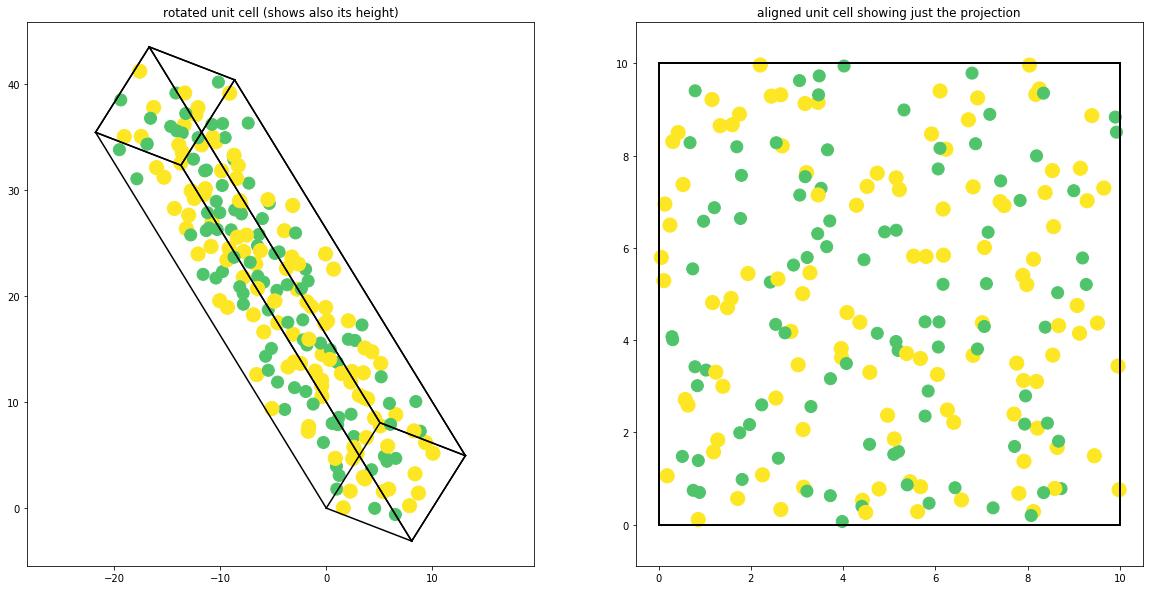

In [7]:
structure = ase.io.read('glass_cube_CuZr.cfg')
Natom = structure.get_number_of_atoms()
unit_cell_volume =structure.get_volume()
unit_cell = structure.get_cell() 
xRange = unit_cell[0,0]
yRange = unit_cell[1,1]
print(Natom," atoms in a super cell volume of ",unit_cell_volume," A^3, area in (001) projection:",xRange,"x",yRange,"A^2\n")
# rotate the cube to make it look 3D:
structure.rotate((1, 1, 1), -np.pi / 4, (0,0,0),True)
p.subplot(1,2,1)
display_unit_cell(structure)
p.title('rotated unit cell (shows also its height)')
# rotate back:
structure.rotate((1, 1, 1), np.pi / 4, (0,0,0),True)
p.subplot(1,2,2)
display_unit_cell(structure)
p.title('aligned unit cell showing just the projection')

# extract the unique symbols in this structure:
uSym,uZ = extractUniqueSymbols(structure)
print("Unique chemical symbols in structure:")
print(uSym)
print(uZ)


Text(0.5, 0, 'Distance in A')

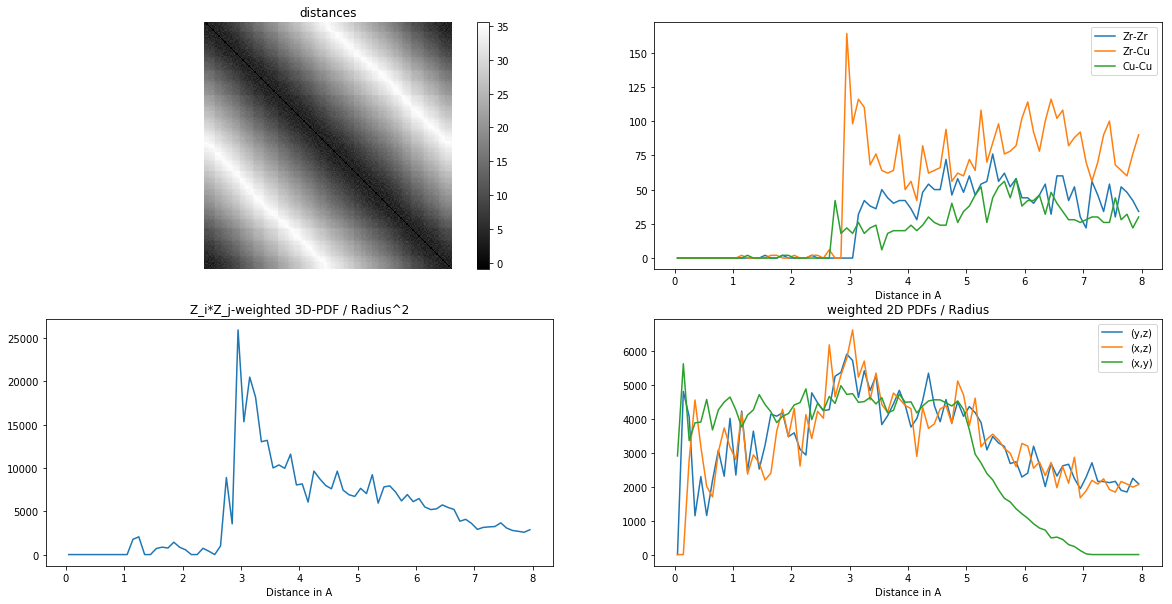

In [8]:
# Compute the partial pair distribution function of our initial structure:
hist, dist, histEdges = computePPDF(structure,binSize=0.1,numBins=80,projectedAxis=None)
showPlot(dist,2,1,"distances")
p.subplot(2,2,2)
distBins = 0.5*(histEdges[1:]+histEdges[0:-1])
h = p.plot(distBins,hist)
p.xlabel("Distance in A")
p.legend(h,['Zr-Zr','Zr-Cu','Cu-Cu'])

hist2D = compute2DPDF(structure,binSize=0.1,numBins=80,projectedAxis=None)
hist2D /= distBins**2
p.subplot(2,2,3)
p.plot(distBins,hist2D)
p.title("Z_i*Z_j-weighted 3D-PDF / Radius^2")
p.xlabel("Distance in A")

p.subplot(2,2,4)
hist2D = compute2DPDF(structure,binSize=0.1,numBins=80,projectedAxis=0)
hist2D /= distBins
h0 = p.plot(distBins,hist2D,label="(y,z)")
hist2D = compute2DPDF(structure,binSize=0.1,numBins=80,projectedAxis=1)
hist2D /= distBins
h1 = p.plot(distBins,hist2D,label="(x,z)")
hist2D = compute2DPDF(structure,binSize=0.1,numBins=80,projectedAxis=2)
hist2D /= distBins
h2 = p.plot(distBins,hist2D,label="(x,y)")
p.legend()
p.title("weighted 2D PDFs / Radius")
p.xlabel("Distance in A")
